In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm #used for creating progress bars for loops and operations. 
warnings.filterwarnings('ignore')
%matplotlib inline  #This is a magic command. ensures that any plots created with matplotlib will be displayed directly in the notebook
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential # It’s a linear stack of layers.
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

In [27]:
#load datset
TRAIN_DIR = 'data_split/train'
TEST_DIR = 'data_split/test'

In [59]:
def load_dataset(directory):
    images = []
    labels = []
    # Walk through the directory
    for label in os.listdir(directory):  # Each label is a folder name
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            for img in os.listdir(label_dir):
                images.append(os.path.join(label_dir, img))  # Full image path
                labels.append(label)  # Folder name is the label
            print(f"{label} Completed")

    return images, labels

In [61]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['emotion'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

anger Completed
contempt Completed
disgust Completed
fear Completed
happiness Completed
neutral Completed
sadness Completed
surprise Completed


,image,emotion
0,data_split/train\neutral\Steve_Alford_0001.jpg,neutral
1,data_split/train\happiness\Justin_Timberlake_0...,happiness
2,data_split/train\neutral\Ron_Dittemore_0007.jpg,neutral
3,data_split/train\neutral\Jose_Maria_Aznar_0006...,neutral
4,data_split/train\happiness\Svetlana_Koroleva_0...,happiness


In [62]:
test = pd.DataFrame()
test['image'], test['emotion'] = load_dataset(TEST_DIR)
test.head()

anger Completed
contempt Completed
disgust Completed
fear Completed
happiness Completed
neutral Completed
sadness Completed
surprise Completed


,image,emotion
0,data_split/test\anger\Alexander_Lukashenko_000...,anger
1,data_split/test\anger\Alvaro_Noboa_0002.jpg,anger
2,data_split/test\anger\Angelina_Jolie_0005.jpg,anger
3,data_split/test\anger\Arnold_Schwarzenegger_00...,anger
4,data_split/test\anger\Billy_Crystal_0004.jpg,anger


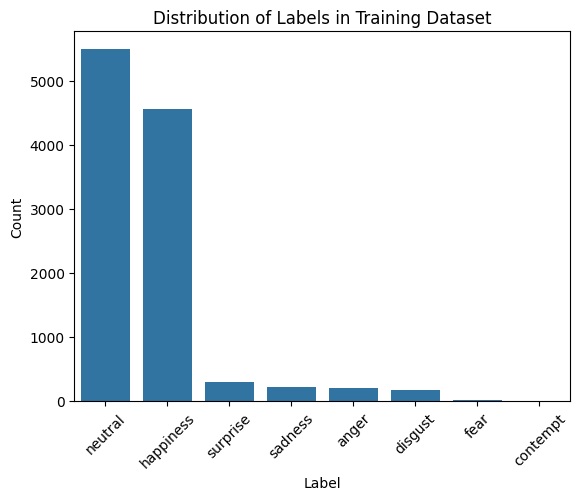

In [69]:

# Count the number of samples for each label
label_counts = train['emotion'].value_counts()

# Plot the counts using Seaborn
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels in Training Dataset')
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
plt.show()

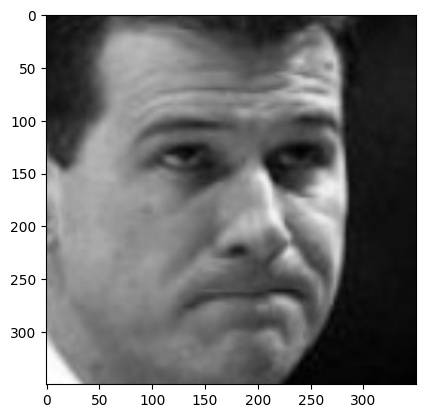

In [70]:
from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img, cmap='gray');

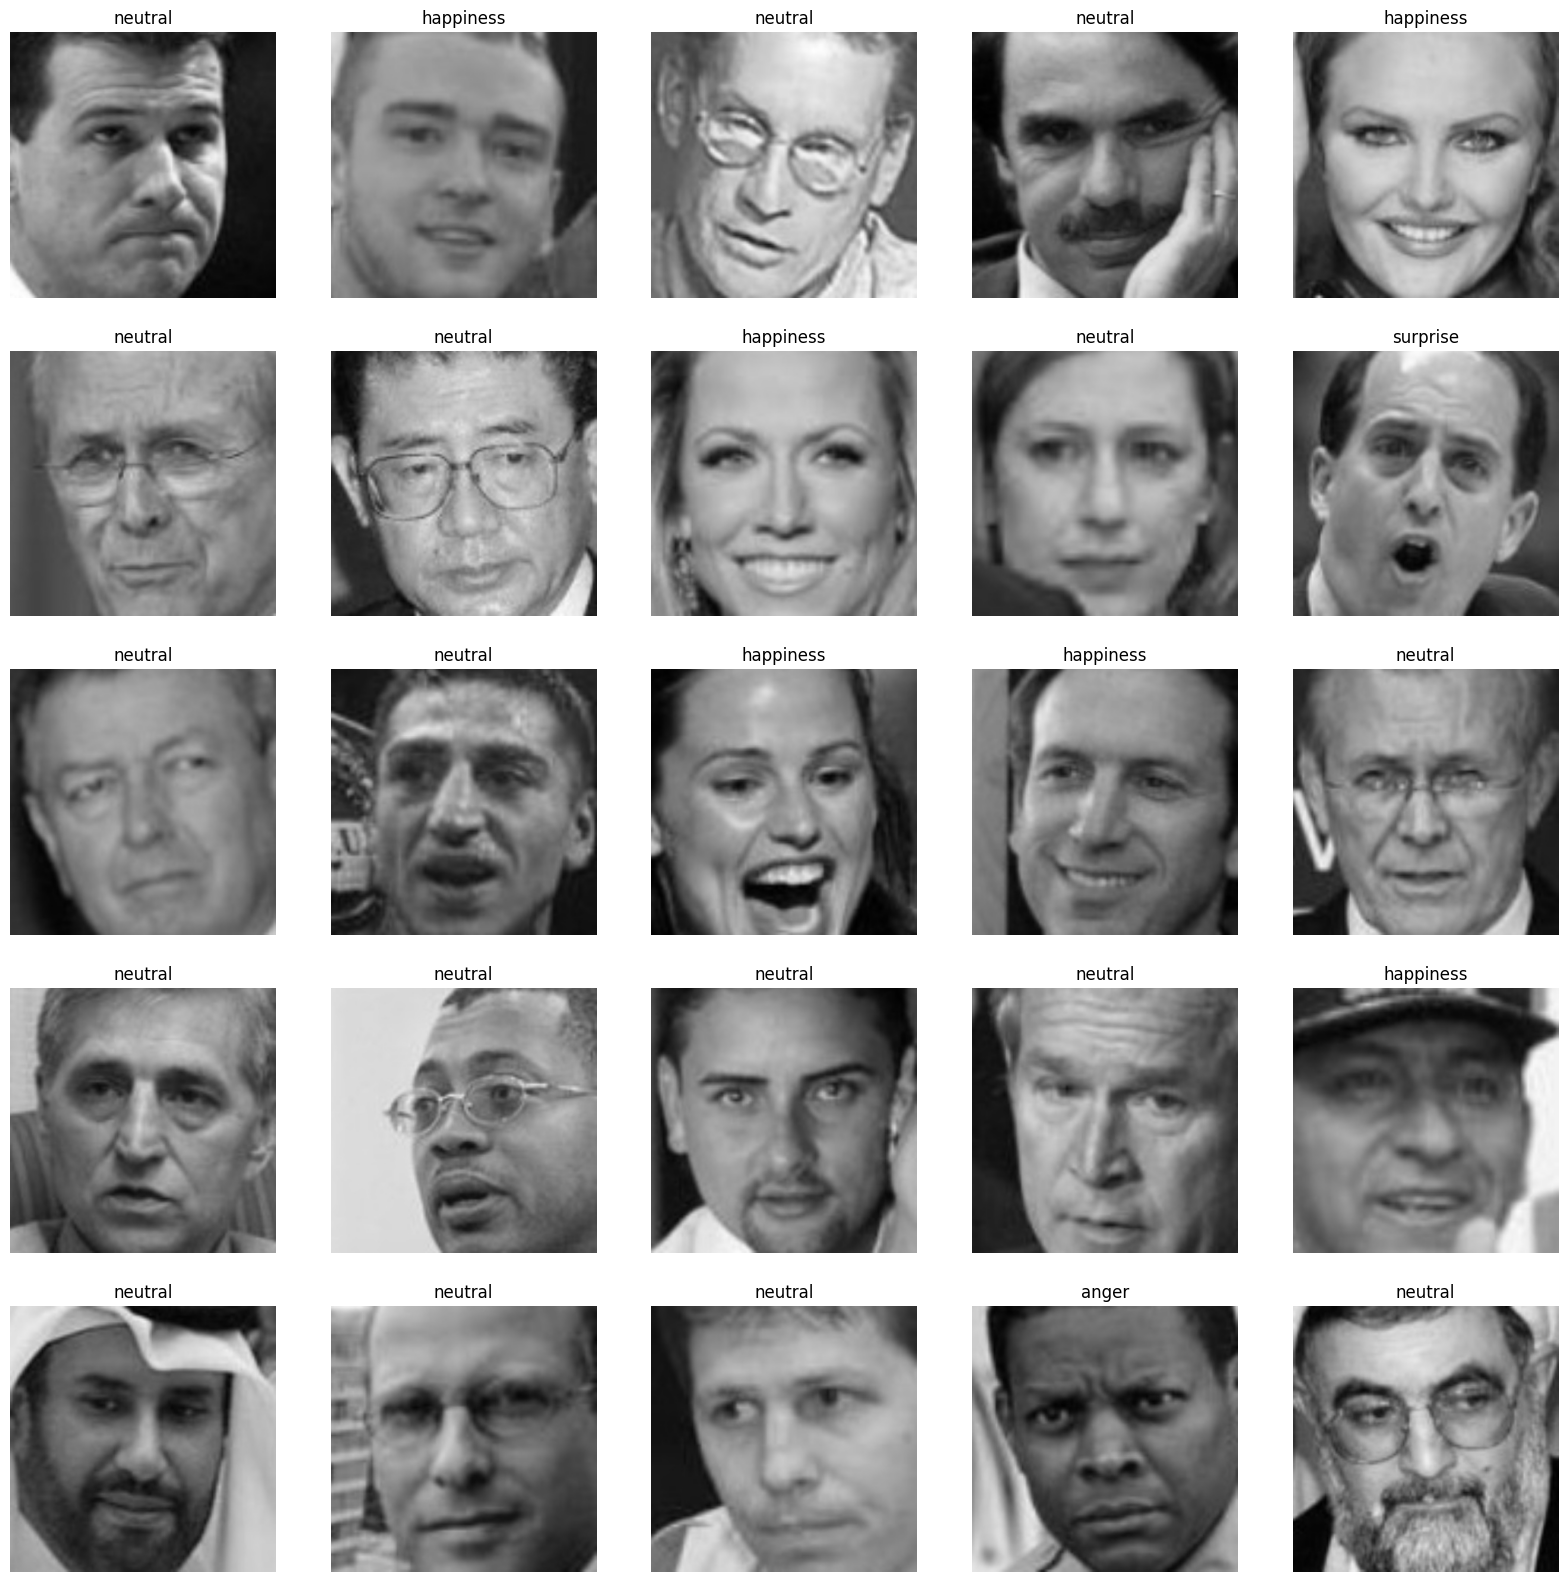

In [71]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

In [74]:
from tensorflow.keras.preprocessing.image import load_img
import numpy as np
from tqdm import tqdm  #used for showing a progress bar during the image loading process.

# Function to extract features from images
def extract_features(images):
    features = []
    for image in tqdm(images):
        # Load image as grayscale
        img = load_img(image, color_mode='grayscale', target_size=(48, 48))  
        img = np.array(img)  # Convert to numpy array
        features.append(img)
    
    # Convert list to numpy array and reshape for model input
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1) 
    return features

# Extract features from train images
train_features = extract_features(train['image'])
print(f"Train features shape: {train_features.shape}")


100%|████████████████████████████████████████████████████████████████████████████| 10947/10947 [01:53<00:00, 96.62it/s]

Train features shape: (10947, 48, 48, 1)


In [75]:
test_features = extract_features(test['image'])

100%|██████████████████████████████████████████████████████████████████████████████| 2738/2738 [00:28<00:00, 96.28it/s]


In [170]:
# normalize the image
x_train = train_features/255.0
x_test = test_features/255.0

In [133]:
#from tensorflow.keras.utils import to_categorical
#from sklearn.model_selection import train_test_split

# Example labels (replace these with your actual labels)
#labels = train['emotion']

# Map class labels (e.g., 'happy', 'sad') to numeric values
#label_mapping = {label: idx for idx, label in enumerate(sorted(labels.unique()))}
#train['numeric_label'] = train['emotion'].map(label_mapping)

# Extract features and labels
#X = train_features  # Extracted features
#y = train['numeric_label']  # Numeric labels

# Split into train and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# One-hot encode the labels
#num_classes = len(label_mapping)  # Number of unique classes
#y_train = to_categorical(y_train, num_classes=num_classes)
#y_test = to_categorical(y_test, num_classes=num_classes)

#print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")


In [171]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['emotion'])
y_train = le.transform(train['emotion'])
y_test = le.transform(test['emotion'])

In [172]:
# config
input_shape = (48, 48, 1)
output_class = 8

Model Creation

In [181]:
model = Sequential()
# convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(output_class, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [182]:
print("y_train shape before max operation:", y_train.shape)
print("y_test shape before max operation:", y_test.shape)


y_train shape before max operation: (10947, 8)
y_test shape before max operation: (2738, 8)


In [183]:
print("Unique values in y_train:", np.unique(y_train))
print("Unique values in y_test:", np.unique(y_test))


Unique values in y_train: [0. 1.]
Unique values in y_test: [0. 1.]


In [190]:
# train the modela
#history = model.fit(x_train, y_train, epochs=2, batch_size=32, validation_data=(x_test, y_test))

history = model.fit(x=x_train, y=y_train, batch_size=32, epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
343/343 ━━━━━━━━━━━━━━━━━━━━ 168s 490ms/step - accuracy: 0.5002 - loss: 1.0228 - val_accuracy: 0.6852 - val_loss: 0.8864
Epoch 2/5
343/343 ━━━━━━━━━━━━━━━━━━━━ 167s 486ms/step - accuracy: 0.6410 - loss: 0.9140 - val_accuracy: 0.7473 - val_loss: 0.7594
Epoch 3/5
343/343 ━━━━━━━━━━━━━━━━━━━━ 169s 492ms/step - accuracy: 0.7049 - loss: 0.8094 - val_accuracy: 0.7389 - val_loss: 0.7280
Epoch 4/5
343/343 ━━━━━━━━━━━━━━━━━━━━ 168s 488ms/step - accuracy: 0.7236 - loss: 0.7707 - val_accuracy: 0.7871 - val_loss: 0.6376
Epoch 5/5
343/343 ━━━━━━━━━━━━━━━━━━━━ 167s 486ms/step - accuracy: 0.7490 - loss: 0.7298 - val_accuracy: 0.7812 - val_loss: 0.6392


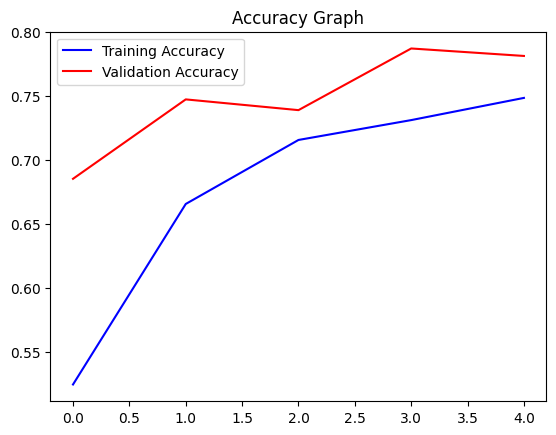

<Figure size 640x480 with 0 Axes>

In [192]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()



plt.show()

In [193]:
model.save('working_model.keras')

Original Output: surprise
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Predicted Output: neutral


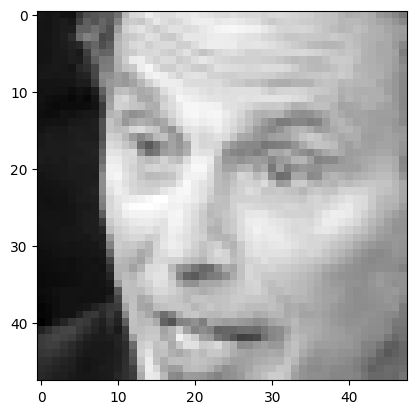

In [194]:
image_index = random.randint(0, len(test))
print("Original Output:", test['emotion'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Original Output: happiness
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Predicted Output: happiness


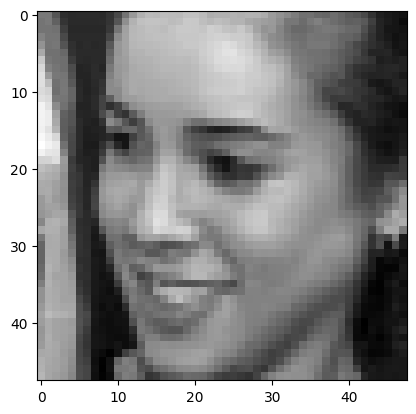

In [195]:
image_index = random.randint(0, len(test))
print("Original Output:", test['emotion'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Original Output: neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Predicted Output: neutral


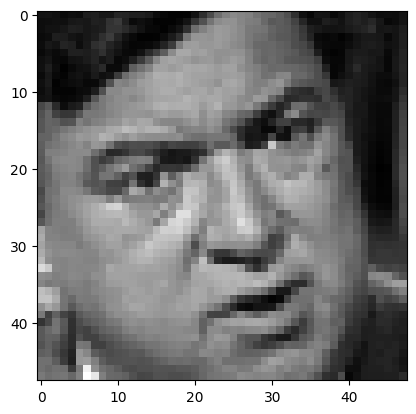

In [196]:
image_index = random.randint(0, len(test))
print("Original Output:", test['emotion'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Original Output: neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Predicted Output: neutral


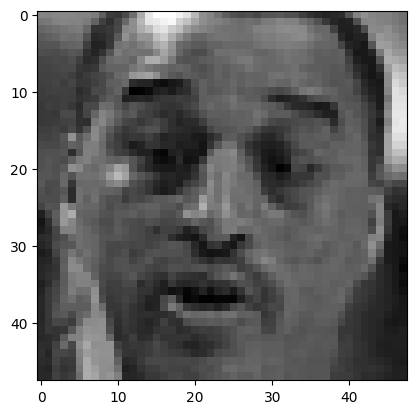

In [197]:
image_index = random.randint(0, len(test))
print("Original Output:", test['emotion'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Original Output: happiness
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Predicted Output: happiness


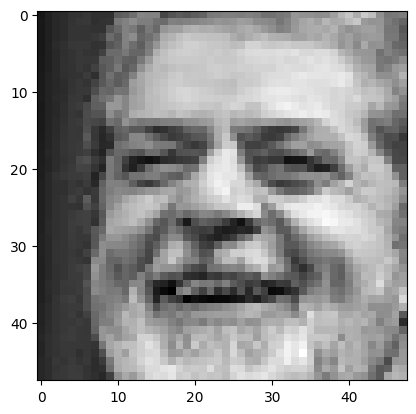

In [198]:
image_index = random.randint(0, len(test))
print("Original Output:", test['emotion'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');